# Comparison of ionization soluations

In [1]:
from copy import deepcopy
from pathlib import Path

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tardis.io.atom_data import AtomData
from tardis.io.configuration.config_reader import Configuration
from tardis.model.base import SimulationState
from tardis.plasma.assembly.base import PlasmaSolverFactory
from tardis.plasma.equilibrium.rates import (
    AnalyticCorrectedPhotoionizationCoeffSolver,
    AnalyticPhotoionizationCoeffSolver,
    SpontaneousRecombinationCoeffSolver,
)
from tardis.plasma.radiation_field import (
    DilutePlanckianRadiationField,
)

home = Path.home()

config = Configuration.from_yaml(home / "tardis/tardis/plasma/tests/data/plasma_base_test_config.yml")

config.supernova.time_explosion = 16.084 * u.day
config.model.structure.type = "file"
config.model.structure.filename = home / "tardis/docs/physics/plasma/equilibrium/cmfgen_stephane_density_rebin.dat"
config.model.structure.filetype = "simple_ascii"
config.model.structure.v_inner_boundary = 10000 * u.km / u.s
config.model.structure.v_outer_boundary = 15000 * u.km / u.s

config.model.abundances.He = 0
config.model.abundances.H = 1

config.plasma.excitation = "dilute-lte"
config.plasma.ionization = "nebular"

ion_slice = (1, slice(None), slice(None), slice(None))

atom_data = AtomData.from_hdf(home / "tardis-regression-data/atom_data/nlte_atom_data/TestNLTE_He_Ti_ctardis.h5")

cmfgen_atom_data2 = deepcopy(atom_data)

cmfgen_radiative_transitions = atom_data.lines.loc[ion_slice, :]

cmfgen_sim_state = SimulationState.from_config(config, atom_data=atom_data)

atom_data.prepare_atom_data([1], "macroatom", [], [(1, 0)])

/home/afullard/tardis/tardis/__init__.py:24: UserWarning: Astropy is already imported externally. Astropy should be imported after TARDIS.
  warnings.warn(


Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

Number of density points larger than number of shells. Assuming inner point irrelevant


# Model setup

In [2]:
from tardis.plasma.electron_energy_distribution import (
    ThermalElectronEnergyDistribution,
)

rad_field = DilutePlanckianRadiationField(np.ones(24) * 10000 * u.K, #9984.96131287 * u.K, 
                                          dilution_factor=np.array(
    [ 0.18635244,  0.15938095,  0.11736085,  0.34665656,  0.32265696,
       0.30224056,  0.28436446,  0.26841929,  0.2540108 ,  0.24086562,
        0.22878441,  0.21761613,  0.20724285,  0.1975702 ,  0.18852112,
        0.18003167,  0.17204798,  0.16452412,  0.15742053,  0.15070279,
        0.14434073,  0.13830767,  0.13257993,  0.12856901]))

electron_dist = ThermalElectronEnergyDistribution(0, np.ones(24) * 10000 * u.K, #9984.96131287 * u.K, 
                                                  np.array(
    [  2.20677509e+09,   1.62501734e+09,   1.22615668e+09,
         9.43891936e+08,   7.38550008e+08,   5.87500741e+08,
         4.72954413e+08,   3.82162389e+08,   3.08702916e+08,
         2.49243299e+08,   2.01203976e+08,   1.62424770e+08,
         1.31111090e+08,   1.05846840e+08,   8.54394007e+07,
         6.89750790e+07,   5.56796014e+07,   4.49524605e+07,
         3.62858202e+07,   2.92940480e+07,   2.36477502e+07,
         1.90900977e+07,   1.54111736e+07,   1.24410890e+07] )* u.cm**-3)

temperature = electron_dist.temperature

# Comparison to cTARDIS rate calculations

Previous rates were calculated using 

cTARDIS

In [3]:
spontaneous_recombination_coeff_solver = SpontaneousRecombinationCoeffSolver(atom_data.photoionization_data,)
photoionization_coeff_solver = AnalyticPhotoionizationCoeffSolver(atom_data.photoionization_data,)

spontaneous_recombination_rate = spontaneous_recombination_coeff_solver.solve(temperature)
photoionization_rate_coeff, stimulated_recombination_rate_coeff = photoionization_coeff_solver.solve(rad_field, temperature)

In [4]:
ctardis_path = "/home/afullard/tardis-chvogl-configs/"

ion_number_density_ctardis = pd.read_csv(ctardis_path+"ion_density.csv", index_col=[0, 1])
lte_ion_number_density_ctardis = pd.read_csv(ctardis_path+"lte_ion_number_density.csv", index_col=[0, 1])

level_number_density_ctardis = pd.read_csv(ctardis_path+"level_pop.csv", index_col=[0])
lte_level_number_density_ctardis = pd.read_csv(ctardis_path+"lte_level_pop.csv", index_col=[0])

correction_factor_ctardis = pd.read_csv(ctardis_path+"correction_factor_ctardis.csv", index_col=[0])

# Build custom property collection

In [5]:
plasma_solver_factory = PlasmaSolverFactory(cmfgen_atom_data2, config)
plasma_solver_factory.prepare_factory([1],"tardis.plasma.properties.property_collections" )
cmfgen_plasma = plasma_solver_factory.assemble(cmfgen_sim_state.elemental_number_density, rad_field, cmfgen_sim_state.time_explosion, electron_dist.number_density, link_t_rad_t_electron=1)

Zeta_data missing - replaced with 1s. Missing ions: []
Zeta_data missing - replaced with 1s. Missing ions: []


# Custom Ion LTE

Differences: Phi at electron temp is VERY CLOSE, LTE partition function is SAME, basic elemental number density is VERY CLOSE, electron densities are VERY CLOSE

LTE and "non-LTE" ion pops in TARDIS plasma are identical right now!

In [6]:
from tardis.plasma.properties.ion_population import IonNumberDensity

class LTEIonNumberDensity(IonNumberDensity):
    outputs = ('lte_ion_number_density', )
    latex_name = ('N_{i,j}^*',)

    def calculate(self, phi_Te, lte_partition_function_Te, number_density, electron_densities, block_ids, ion_threshold):
        return self.calculate_with_n_electron(
            phi_Te, lte_partition_function_Te, number_density, electron_densities, block_ids, ion_threshold)

# Custom level LTE

Check input values for calculations use LTE or "NLTE" quantities as appropriate

Check precisely what step values are sourced from- are these first iteration or not?


In [7]:
from tardis.plasma.properties.level_population import (
    LevelNumberDensity,
)

class LTELevelNumberDensity(LevelNumberDensity):
    outputs = ('lte_level_number_density',)
    latex_name = ('N_{i,j,k}^*',)

    def _calculate_dilute_lte(self, lte_level_boltzmann_factor_Te, lte_ion_number_density,
                              levels, lte_partition_function_Te):
        return super(LTELevelNumberDensity, self)._calculate_dilute_lte(
            lte_level_boltzmann_factor_Te, lte_ion_number_density, levels, lte_partition_function_Te)

In [8]:
lte_ion_number_density = LTEIonNumberDensity(cmfgen_plasma,
                                             electron_densities=cmfgen_plasma.electron_densities
                                             ).calculate(
                                                 cmfgen_plasma.thermal_phi_lte,
                                                 cmfgen_plasma.thermal_lte_partition_function,
                                                 cmfgen_sim_state.elemental_number_density,
                                                 cmfgen_plasma.electron_densities,
                                                 None, 1e-20)[0]

In [9]:
lte_level_number_density = LTELevelNumberDensity(cmfgen_plasma
                                                 ).calculate(
                                                     cmfgen_plasma.thermal_lte_level_boltzmann_factor,
                                                     lte_ion_number_density,
                                                     cmfgen_plasma.levels,
                                                     cmfgen_plasma.thermal_lte_partition_function)

### NB- not really a "Saha Factor", this is $\Phi_{i,\kappa}$ as defined in Lucy 03 Eq 14

In [ ]:
level_to_ion_population_factor = lte_level_number_density.loc[lte_level_number_density.index.get_level_values('ion_number') < 1] / (
            lte_ion_number_density.loc[lte_ion_number_density.index.get_level_values('ion_number') >= 1].values
            * electron_dist.number_density.value
        )

In [ ]:
level_to_ion_population_factor_ctardis = pd.read_csv(ctardis_path+"phi_lucy.csv", index_col=[0, 1, 2])

<Axes: xlabel='atomic_number,ion_number,level_number'>

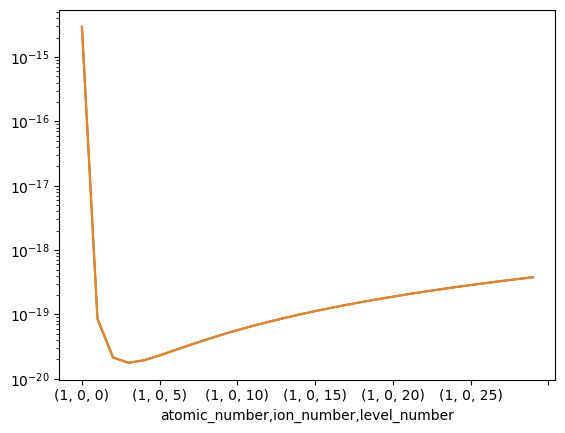

In [ ]:
level_to_ion_population_factor_ctardis["0"].plot(logy=True)
level_to_ion_population_factor[0].plot(logy=True)

In [ ]:
level_to_ion_population_factor.loc[(1,0,0)]

0     2.954267e-15
1     2.954267e-15
2     2.954267e-15
3     2.954267e-15
4     2.954267e-15
5     2.954267e-15
6     2.954267e-15
7     2.954267e-15
8     2.954267e-15
9     2.954267e-15
10    2.954267e-15
11    2.954267e-15
12    2.954267e-15
13    2.954267e-15
14    2.954267e-15
15    2.954267e-15
16    2.954267e-15
17    2.954267e-15
18    2.954267e-15
19    2.954267e-15
20    2.954267e-15
21    2.954267e-15
22    2.954267e-15
23    2.954267e-15
Name: (1, 0, 0), dtype: float64

<Axes: xlabel='atomic_number,ion_number,level_number'>

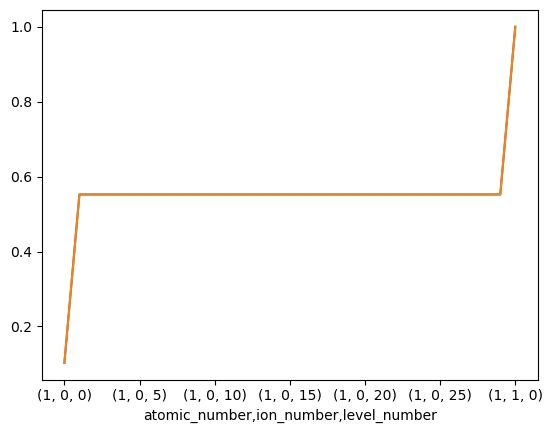

In [14]:
(lte_level_number_density_ctardis["0"] / level_number_density_ctardis["0"]).plot()
(lte_level_number_density[0] / cmfgen_plasma.level_number_density[0]).plot()

<Axes: xlabel='atomic_number,ion_number'>

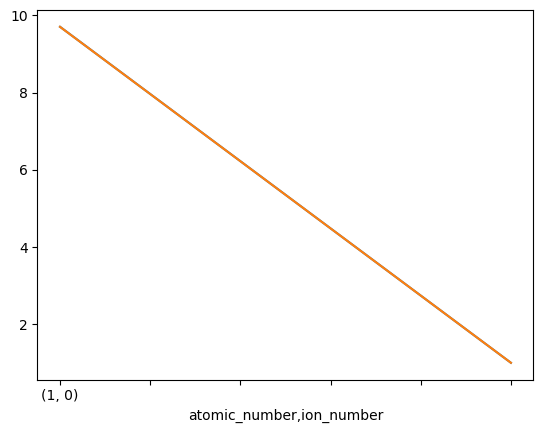

In [15]:
(ion_number_density_ctardis["0"] / lte_ion_number_density_ctardis["0"]).plot()
(cmfgen_plasma.ion_number_density[0] / lte_ion_number_density[0]).plot()

<Axes: xlabel='atomic_number,ion_number,level_number'>

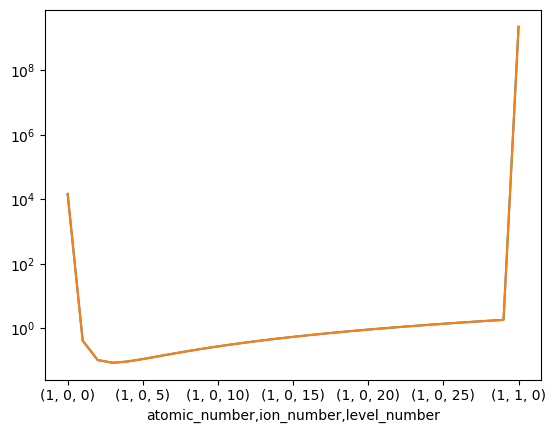

In [16]:
lte_level_number_density_ctardis["0"].plot(logy=True)
lte_level_number_density[0].plot(logy=True)

<Axes: xlabel='atomic_number,ion_number'>

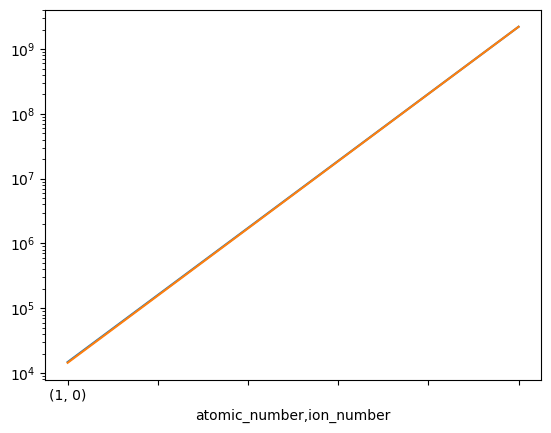

In [17]:
lte_ion_number_density_ctardis["0"].plot(logy=True)
lte_ion_number_density[0].plot(logy=True)

<Axes: xlabel='atomic_number,ion_number'>

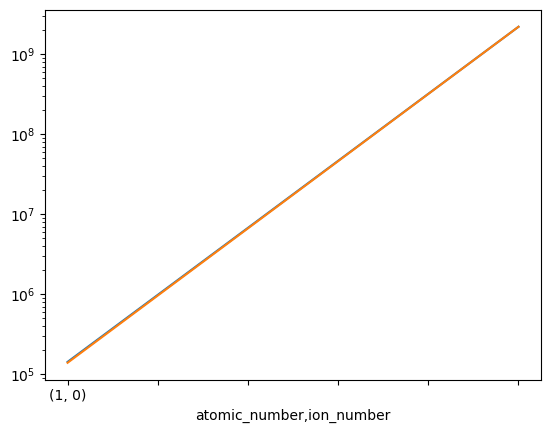

In [18]:
ion_number_density_ctardis["0"].plot(logy=True)
cmfgen_plasma.ion_number_density[0].plot(logy=True)

## Photoionization coefficients

In [19]:
from tardis.plasma.equilibrium.rates import AnalyticPhotoionizationRateSolver

photoionization_rate_solver = AnalyticPhotoionizationRateSolver(atom_data.photoionization_data)
corr_photoion_coeff_solver = AnalyticCorrectedPhotoionizationCoeffSolver(atom_data.photoionization_data)

In [20]:
corr_photoion_coeff = corr_photoion_coeff_solver.solve(
    rad_field,
    electron_dist.temperature,
    lte_level_number_density.loc[lte_level_number_density.index.get_level_values('ion_number') < 1],
    cmfgen_plasma.level_number_density.loc[cmfgen_plasma.level_number_density.index.get_level_values('ion_number') < 1],
    lte_ion_number_density.loc[lte_ion_number_density.index.get_level_values('ion_number') >= 1],
    cmfgen_plasma.ion_number_density.loc[cmfgen_plasma.ion_number_density.index.get_level_values('ion_number') >= 1],
    )

In [21]:
photoionization_coeff_ctardis = pd.read_csv("/home/afullard/tardis-chvogl-configs/rate_coefficients.csv", index_col=[0, 1, 2], skiprows=16)
estimated_photoion_coeff_ctardis = pd.read_csv(ctardis_path+"estimated_photoion_coeff.csv", index_col=[0, 1, 2])

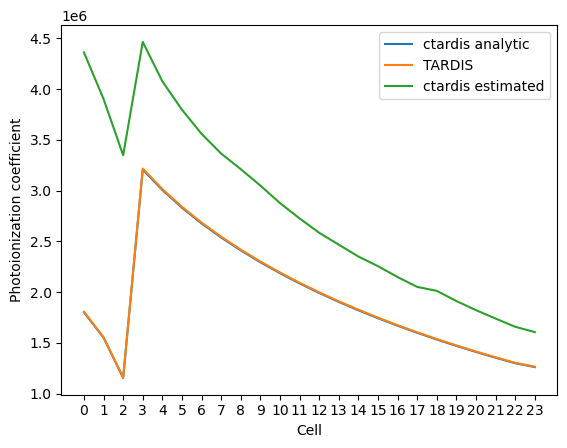

In [22]:
df1 = photoionization_coeff_ctardis.groupby(
            level=("atomic_number", "ion_number")
        ).sum()
df2 = corr_photoion_coeff.groupby(
            level=("atomic_number", "ion_number")
        ).sum()
df3 = estimated_photoion_coeff_ctardis.groupby(
            level=("atomic_number", "ion_number")
        ).sum()


plt.plot(df1.T, label="ctardis analytic")
plt.plot(df2.T, label="TARDIS")
plt.plot(df3.T, label="ctardis estimated")
plt.xlabel("Cell")
plt.ylabel("Photoionization coefficient")
plt.legend()

/tmp/ipykernel_373396/3826348831.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


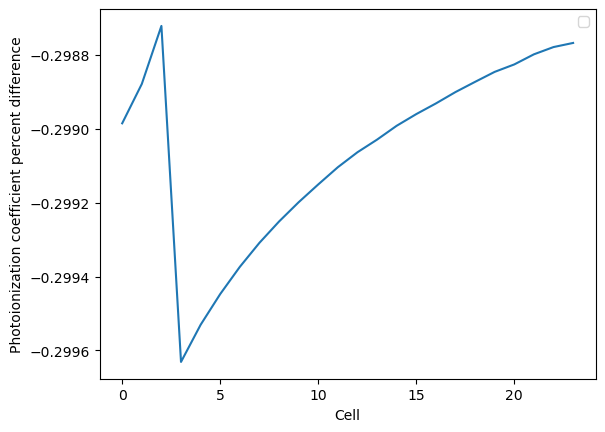

In [23]:
plt.plot((df1.T.values - df2.T.values)/df2.T.values * 100)
#plt.plot(df3.T, label="TARDIS")
plt.xlabel("Cell")
plt.ylabel("Photoionization coefficient percent difference")
plt.legend()

## Recombination rates

In [24]:
from tardis.plasma.equilibrium.rates import SpontaneousRecombinationCoeffSolver

recomb_rate_solver = SpontaneousRecombinationCoeffSolver(atom_data.photoionization_data)

recomb_coeff = recomb_rate_solver.solve(electron_dist.temperature)

In [ ]:
recomb_coeff_ctardis_iter1 = pd.read_csv(ctardis_path+"sp_recomb_coeff_iter1.csv", index_col=[0, 1, 2])
recomb_coeff_ctardis_iter2 = pd.read_csv(ctardis_path+"sp_recomb_coeff_iter2.csv", index_col=[0, 1, 2])
recomb_coeff_ctardis_iter3 = pd.read_csv(ctardis_path+"sp_recomb_coeff_iter3.csv", index_col=[0, 1, 2])

recomb_coeff_comparison = (recomb_coeff * level_to_ion_population_factor)

<Axes: xlabel='atomic_number,ion_number,level_number'>

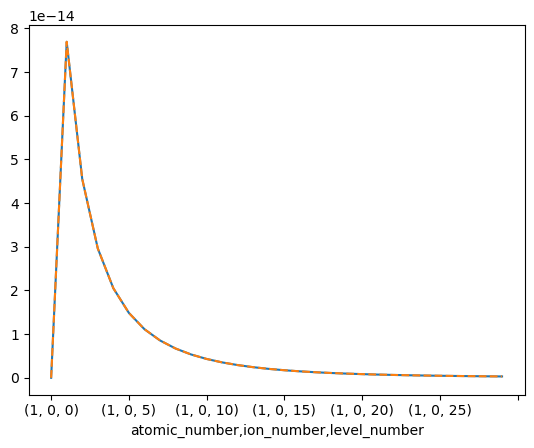

In [26]:
recomb_coeff_ctardis_iter1["0"].plot()
recomb_coeff_comparison[0].plot(ls="--")

<Axes: xlabel='atomic_number,ion_number,level_number'>

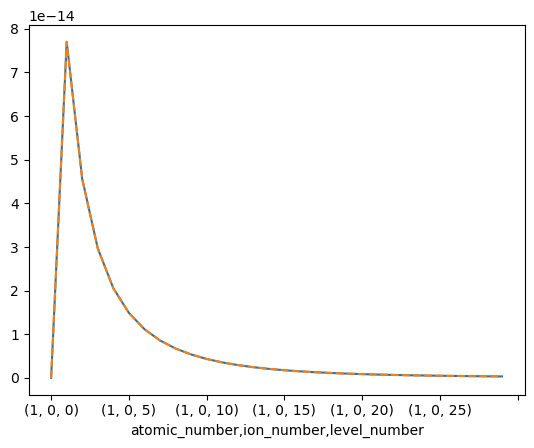

In [27]:
recomb_coeff_ctardis_iter2["0"].plot()
recomb_coeff_comparison[0].plot(ls="--")

<Axes: xlabel='atomic_number,ion_number,level_number'>

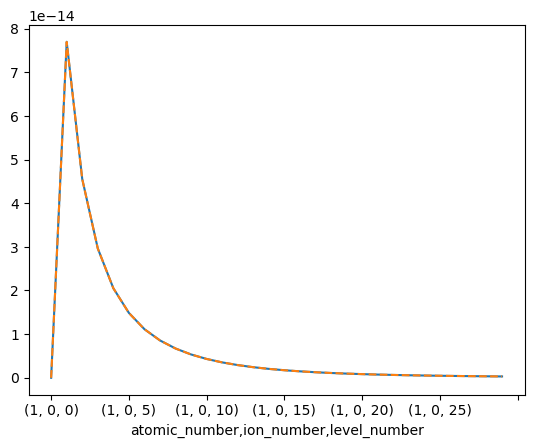

In [28]:
recomb_coeff_ctardis_iter3["0"].plot()
recomb_coeff_comparison[0].plot(ls="--")

/tmp/ipykernel_373396/2625515403.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot((recomb_coeff_ctardis_iter1["0"].values - recomb_coeff_comparison[0].values)/recomb_coeff_comparison[0].values * 100, label="ctardis iter1")
/tmp/ipykernel_373396/2625515403.py:2: RuntimeWarning: invalid value encountered in divide
  plt.plot((recomb_coeff_ctardis_iter2["0"].values - recomb_coeff_comparison[0].values)/recomb_coeff_comparison[0].values * 100, label="ctardis iter2")
/tmp/ipykernel_373396/2625515403.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot((recomb_coeff_ctardis_iter3["0"].values - recomb_coeff_comparison[0].values)/recomb_coeff_comparison[0].values * 100, label="ctardis iter3")


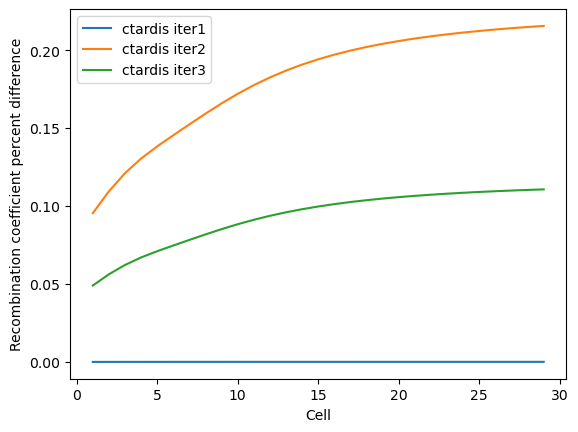

In [29]:
plt.plot((recomb_coeff_ctardis_iter1["0"].values - recomb_coeff_comparison[0].values)/recomb_coeff_comparison[0].values * 100, label="ctardis iter1")
plt.plot((recomb_coeff_ctardis_iter2["0"].values - recomb_coeff_comparison[0].values)/recomb_coeff_comparison[0].values * 100, label="ctardis iter2")
plt.plot((recomb_coeff_ctardis_iter3["0"].values - recomb_coeff_comparison[0].values)/recomb_coeff_comparison[0].values * 100, label="ctardis iter3")
plt.xlabel("Cell")
plt.ylabel("Recombination coefficient percent difference")
plt.legend()

## Level population fractions

Scaling factor to compensate for solving the ion and level populations independently

<Axes: xlabel='atomic_number,ion_number,level_number'>

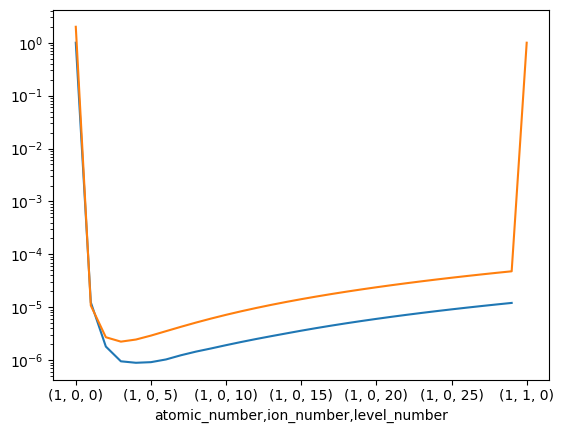

In [30]:
level_pop_fraction_ctardis = pd.read_csv(ctardis_path+"level_pop_fractions.csv", index_col=[0, 1, 2])
level_pop_fraction_ctardis.columns = level_pop_fraction_ctardis.columns.astype(int)

level_pop_fraction_ctardis[0].T.plot(logy=True)
(cmfgen_plasma.level_boltzmann_factor / cmfgen_plasma.partition_function.loc[(1,1)])[0].T.plot(logy=True)

In [31]:
cmfgen_plasma.number_density

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
atomic_number,,,,,,,,,,,,,,,,,,,,,
1,2.206974e+09,1.625151e+09,1.226263e+09,9.439276e+08,7.385766e+08,5.875210e+08,4.729701e+08,3.821747e+08,3.087125e+08,2.492508e+08,...,8.544174e+07,6.897694e+07,5.568109e+07,4.495365e+07,3.628677e+07,2.929481e+07,2.364836e+07,1.909059e+07,1.541157e+07,1.244141e+07


### Effects of differing level population fractions on the photoionization rate

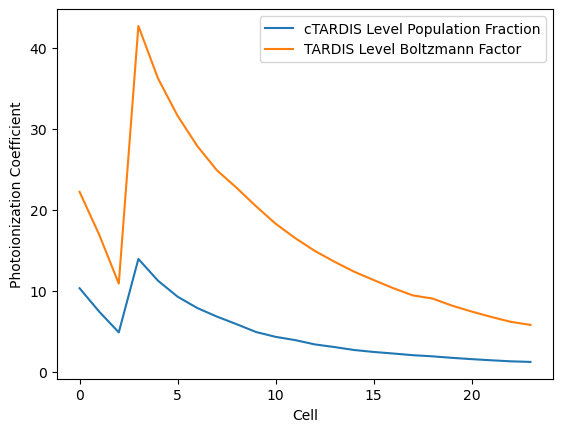

In [32]:
plt.plot((estimated_photoion_coeff_ctardis.values * level_pop_fraction_ctardis.values).sum(axis=0).T, label="cTARDIS Level Population Fraction")
plt.plot((estimated_photoion_coeff_ctardis.values * cmfgen_plasma.level_boltzmann_factor.loc[1,0].values).sum(axis=0).T, label="TARDIS Level Boltzmann Factor")
plt.xlabel("Cell")
plt.ylabel("Photoionization Coefficient")
plt.legend()

## Solving photoionization and recombination rates using CTARDIS input

In [33]:
boltzmann_factor_ctardis = pd.read_csv(ctardis_path+"level_boltzmann_factor_ctardis.csv", index_col=[0, 1, 2])
boltzmann_factor_ctardis.columns = boltzmann_factor_ctardis.columns.astype(int)

photoion_rates, recomb_rates = photoionization_rate_solver.solve(rad_field, electron_dist, lte_level_number_density.loc[lte_level_number_density.index.get_level_values('ion_number') < 1], 
    cmfgen_plasma.level_number_density.loc[cmfgen_plasma.level_number_density.index.get_level_values('ion_number') < 1],
    lte_ion_number_density.loc[lte_ion_number_density.index.get_level_values('ion_number') >= 1],
    cmfgen_plasma.ion_number_density.loc[cmfgen_plasma.ion_number_density.index.get_level_values('ion_number') >= 1],
    1.0, # Partition function to match ctardis
    boltzmann_factor_ctardis,
   )

<Axes: >

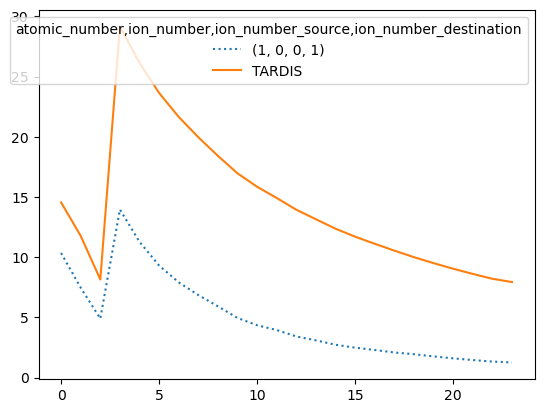

In [34]:
photoion_rates_ctardis = pd.read_csv(ctardis_path+"photoion_tot.csv", index_col=[0, 1])
photoion_rates_ctardis.columns = photoion_rates_ctardis.columns.astype(int)

photoion_rates_ctardis.reset_index(inplace=True)

photoion_rates_ctardis["ion_number_destination"] = photoion_rates_ctardis["ion_number"] + 1
photoion_rates_ctardis["ion_number_source"] = photoion_rates_ctardis["ion_number"]
photoion_rates_ctardis.set_index(['atomic_number', 'ion_number', 'ion_number_source', 'ion_number_destination'], inplace=True)

photoion_rates_ctardis = photoion_rates_ctardis.iloc[:-1]

photoion_rates_ctardis.T.plot(label="ctardis", ls = ":")
photoion_rates.sum().plot(label="TARDIS",legend=True)

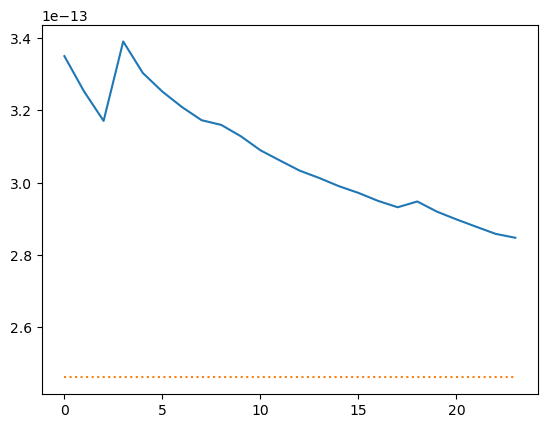

In [35]:
recomb_rates_ctardis = pd.read_csv(ctardis_path+"recomb_tot.csv", index_col=[0, 1])
recomb_rates_ctardis.columns = recomb_rates_ctardis.columns.astype(int)

recomb_rates_ctardis.reset_index(inplace=True)

recomb_rates_ctardis["ion_number_destination"] = recomb_rates_ctardis["ion_number"]
recomb_rates_ctardis["ion_number_source"] = recomb_rates_ctardis["ion_number"] + 1

recomb_rates_ctardis.set_index(['atomic_number', 'ion_number', 'ion_number_source', 'ion_number_destination'], inplace=True)

recomb_rates_ctardis = recomb_rates_ctardis.iloc[:-1]

plt.plot(recomb_rates_ctardis.T)
plt.plot(recomb_rates.sum() / electron_dist.number_density.value, ls=":")

# Collisional rates

Match both pre- and post- estimator rates from ctardis

In [36]:
from tardis.plasma.equilibrium.rate_matrix import IonRateMatrix
from tardis.plasma.equilibrium.rates import CollisionalIonizationRateSolver

collisional_rate_solver = CollisionalIonizationRateSolver(atom_data.photoionization_data)

In [ ]:
coll_ion_rates, coll_recomb_rates = collisional_rate_solver.solve(
    electron_dist, 
    level_to_ion_population_factor, 
    1.0,
    boltzmann_factor_ctardis,)

Text(0, 0.5, 'Collisional Ionization Coefficient')

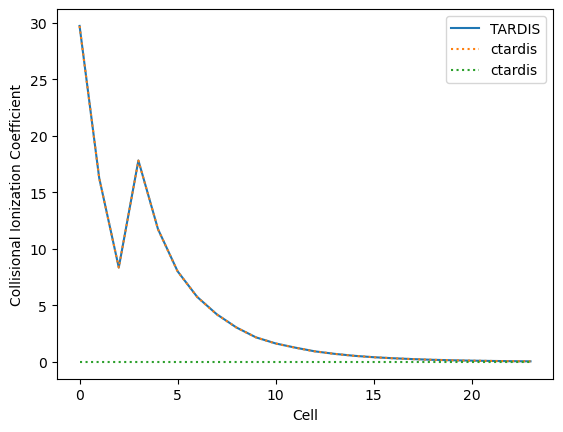

In [38]:
tardis_coll_ion = coll_ion_rates.groupby(level=("atomic_number", "ion_number")).sum().T
coll_ion_coeff_ctardis = pd.read_csv(ctardis_path+"coll_ion_total.csv", index_col=[0, 1])
coll_ion_coeff_ctardis.columns = coll_ion_coeff_ctardis.columns.astype(int)

coll_ion_coeff_ctardis.reset_index(inplace=True)

coll_ion_coeff_ctardis["ion_number_source"] = coll_ion_coeff_ctardis["ion_number"]
coll_ion_coeff_ctardis["ion_number_destination"] = coll_ion_coeff_ctardis["ion_number"] + 1

coll_ion_coeff_ctardis.set_index(['atomic_number', 'ion_number', 'ion_number_source', 'ion_number_destination'], inplace=True)


ctardis_coll_ion = (coll_ion_coeff_ctardis.groupby(level=("atomic_number", "ion_number")).sum() * electron_dist.number_density).T

plt.plot(tardis_coll_ion, label="TARDIS")
plt.plot(ctardis_coll_ion, label="ctardis", ls=':')
plt.legend()
plt.xlabel("Cell")
plt.ylabel("Collisional Ionization Coefficient")

Text(0, 0.5, 'Collisional Recombination Coefficient')

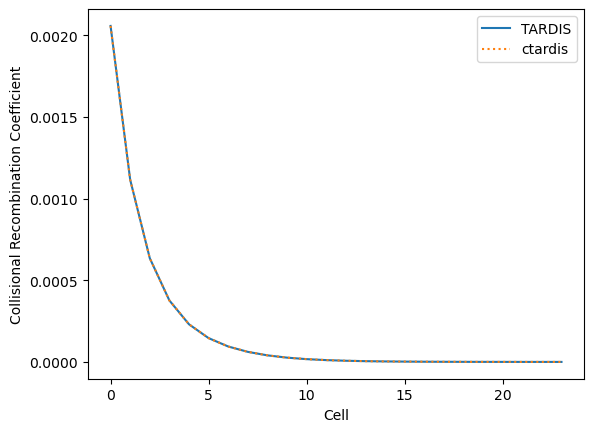

In [39]:
tardis_coll_recomb = coll_recomb_rates.groupby(level=("atomic_number", "ion_number")).sum().T
coll_recomb_coeff_ctardis = pd.read_csv(ctardis_path+"coll_recomb_coeff_ctardis.csv", index_col=[0, 1, 2])
coll_recomb_coeff_ctardis = coll_recomb_coeff_ctardis.groupby(level=("atomic_number", "ion_number")).sum() * electron_dist.number_density **2
coll_recomb_coeff_ctardis.columns = coll_recomb_coeff_ctardis.columns.astype(int)

coll_recomb_coeff_ctardis.reset_index(inplace=True)

coll_recomb_coeff_ctardis["ion_number_source"] = coll_recomb_coeff_ctardis["ion_number"] + 1
coll_recomb_coeff_ctardis["ion_number_destination"] = coll_recomb_coeff_ctardis["ion_number"]

coll_recomb_coeff_ctardis.set_index(['atomic_number', 'ion_number', 'ion_number_source', 'ion_number_destination'], inplace=True)


ctardis_coll_recomb = coll_recomb_coeff_ctardis.T

plt.plot(tardis_coll_recomb, label="TARDIS")
plt.plot(ctardis_coll_recomb, label="ctardis",  ls=':')
plt.legend()
plt.xlabel("Cell")
plt.ylabel("Collisional Recombination Coefficient")

In [40]:
class dummyphotoionratesolver:
    """Dummy solver to hold ctardis data"""
    def __init__(self, ctardis_photoion_rates, ctardis_recomb_rates):
        self.photoion_rates = ctardis_photoion_rates
        self.recomb_rates = ctardis_recomb_rates
    def solve(self, rad_field, electron_dist, level_population, lte_level_population, lte_ion_number_density=None, ion_number_density=None, x=None, y=None):
        return self.photoion_rates, self.recomb_rates

dummy_rate_solver = dummyphotoionratesolver(photoion_rates_ctardis, recomb_rates_ctardis * electron_dist.number_density)
dummy_col_rate_solver = dummyphotoionratesolver(coll_ion_rates, coll_recomb_coeff_ctardis)

ion_rate_matrix_solver = IonRateMatrix(dummy_rate_solver, collisional_rate_solver)

# Ion rate matrix

In [41]:
ion_rate_matrix = ion_rate_matrix_solver.solve(rad_field, electron_dist, lte_level_number_density.loc[lte_level_number_density.index.get_level_values('ion_number') < 1], 
    cmfgen_plasma.level_number_density.loc[cmfgen_plasma.level_number_density.index.get_level_values('ion_number') < 1],
    lte_ion_number_density.loc[lte_ion_number_density.index.get_level_values('ion_number') >= 1],
    cmfgen_plasma.ion_number_density.loc[cmfgen_plasma.ion_number_density.index.get_level_values('ion_number') >= 1],
    1.0,
    boltzmann_factor_ctardis,
    charge_conservation=True)

In [42]:
from tardis.plasma.equilibrium.ion_populations import IonPopulationSolver

solver = IonPopulationSolver(ion_rate_matrix_solver)

ion_pops, electron_densities = solver.solve(
    rad_field,
    electron_dist,
    cmfgen_sim_state.elemental_number_density,
    lte_level_number_density,
    cmfgen_plasma.level_number_density,
    lte_ion_number_density,
    cmfgen_plasma.ion_number_density,
    1.0,
    boltzmann_factor_ctardis,
    charge_conservation=False)

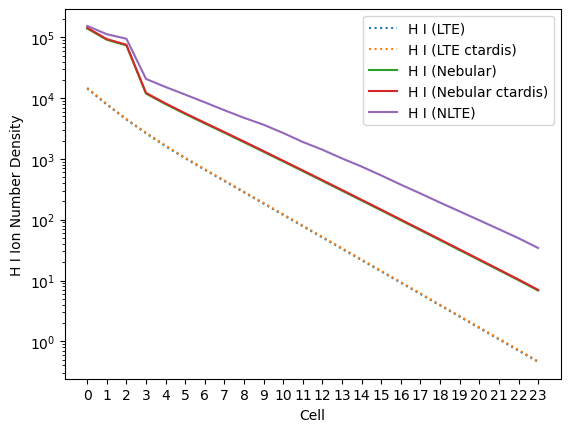

In [43]:
plt.plot(lte_ion_number_density.T.iloc[:, 0], label='H I (LTE)', ls=":")
plt.plot(lte_ion_number_density_ctardis.T.iloc[:, 0], label='H I (LTE ctardis)', ls=":")
plt.plot(cmfgen_plasma.ion_number_density.T.iloc[:, 0], label='H I (Nebular)')
plt.plot(ion_number_density_ctardis.T.iloc[:, 0], label='H I (Nebular ctardis)')
plt.plot(ion_pops.T.iloc[:, 0], label='H I (NLTE)')
plt.xlabel("Cell")
plt.ylabel("H I Ion Number Density")
plt.semilogy()
plt.legend()

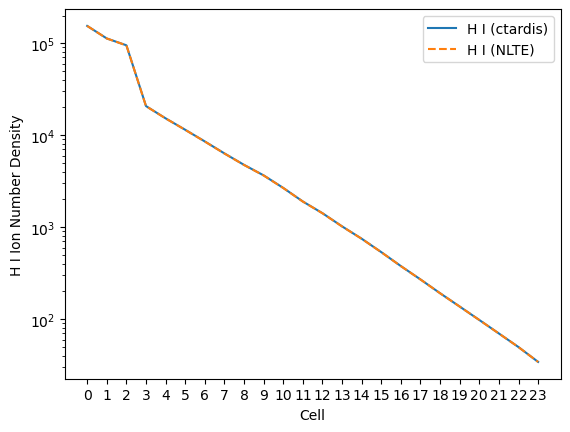

In [44]:
ion_number_density_ctardis_final = pd.read_csv(ctardis_path+"ion_number_densities_ctardis_result.csv", index_col=[0, 1])

plt.plot(ion_number_density_ctardis_final.T.iloc[:, 0], label='H I (ctardis)')
plt.plot(ion_pops.T.iloc[:, 0], label='H I (NLTE)', ls="--")
plt.xlabel("Cell")
plt.ylabel("H I Ion Number Density")
plt.semilogy()
plt.legend()

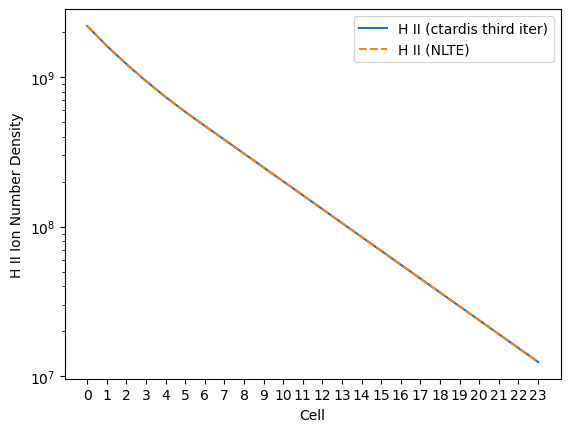

In [45]:
plt.plot(ion_number_density_ctardis_final.T.iloc[:, 1], label='H II (ctardis third iter)')
plt.plot(ion_pops.T.iloc[:, 1], label='H II (NLTE)', ls="--")
plt.xlabel("Cell")
plt.ylabel("H II Ion Number Density")
plt.semilogy()
plt.legend()

Text(0.5, 1.0, 'Percentage Residuals of H I NLTE vs H I CTARDIS')

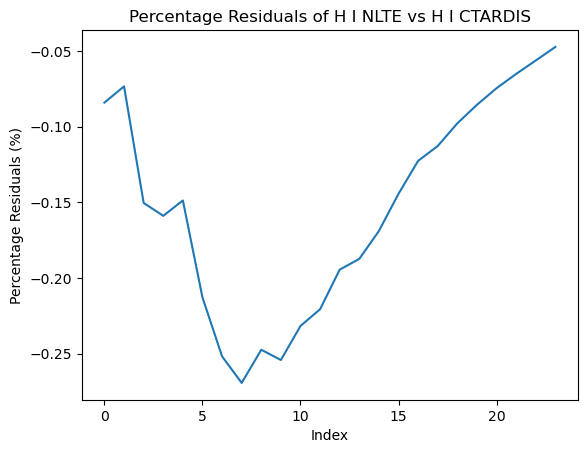

In [46]:
residuals = ((ion_pops.T.iloc[:, 0].values - ion_number_density_ctardis_final.T.iloc[:, 0].values) / ion_number_density_ctardis_final.T.iloc[:, 0].values) * 100
plt.plot(residuals, label='Percentage Residuals (H I NLTE - H I CTARDIS)')
plt.xlabel('Index')
plt.ylabel('Percentage Residuals (%)')
plt.title('Percentage Residuals of H I NLTE vs H I CTARDIS')

Text(0.5, 1.0, 'Percentage Residuals of H II NLTE vs H II CTARDIS')

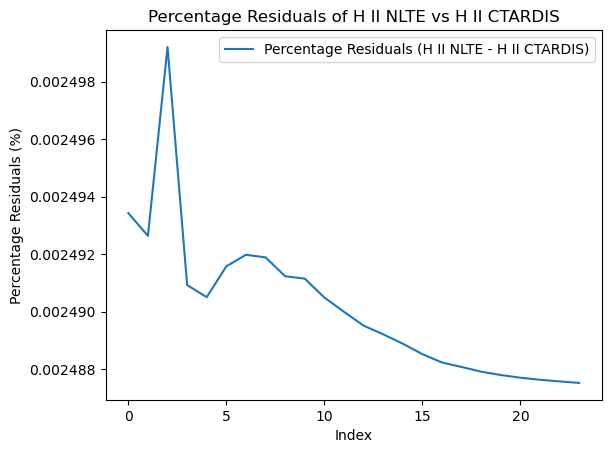

In [47]:
residuals_hii = ((ion_pops.T.iloc[:, 1].values - ion_number_density_ctardis_final.T.iloc[:, 1].values) / ion_number_density_ctardis_final.T.iloc[:, 1].values) * 100
plt.plot(residuals_hii, label='Percentage Residuals (H II NLTE - H II CTARDIS)')
plt.xlabel('Index')
plt.ylabel('Percentage Residuals (%)')
plt.legend()
plt.title('Percentage Residuals of H II NLTE vs H II CTARDIS')

Text(0.5, 1.0, 'Percentage Residuals of e NLTE vs e ctardis')

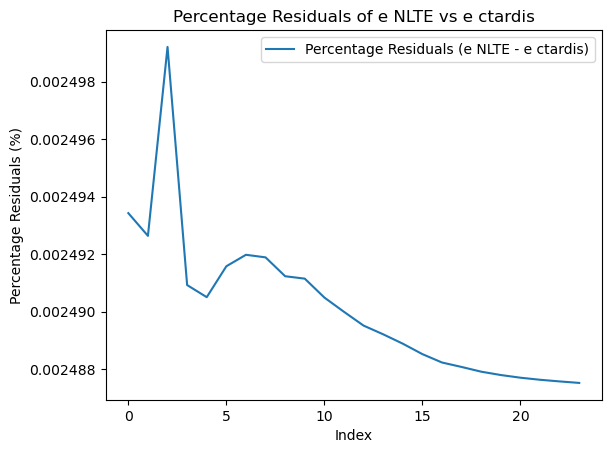

In [48]:
electron_densities_ctardis = pd.read_csv(ctardis_path+"electron_densities_ctardis_result.csv", index_col=0, header=None)

residuals_electron= ((electron_densities - electron_densities_ctardis[1]) / electron_densities_ctardis[1]) * 100
plt.plot(residuals_electron, label='Percentage Residuals (e NLTE - e ctardis)')
plt.xlabel('Index')
plt.ylabel('Percentage Residuals (%)')
plt.legend()
plt.title('Percentage Residuals of e NLTE vs e ctardis')